# Data Exploration

## loading in Data and connecting to drive

In [2]:
import os

# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# Bubs
df = pd.read_excel('/content/drive/My Drive/Masters Thesis/Colab notebook/Sentiment analysis/RoBERTa_sentiment_preds_reply.xlsx')

# Sebs
#final_data = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/Sentiment analysis/RoBERTa_sentiment_preds_reply.xlsx')

In [4]:
df.columns

Index(['Author_Handle', 'Date', 'X_Post', 'Reply_Count', 'Repost_Count',
       'Like_Count', 'View_Count', 'Follower_Count', 'Verified_Status',
       'Prediction', 'Confidence', 'Replying_to'],
      dtype='object')

In [ ]:
print("Start date:", df['Date'].min())
print("End date:", df['Date'].max())

Start date: 2022-01-01 00:13:32
End date: 2024-12-30 23:59:14


In [ ]:
# Splitting 60/20/20

# Ensure date is datetime
df['date'] = pd.to_datetime(df['Date'])

# Define split points
train_end = '2023-10-31'
val_end = '2024-05-31'

# Create splits
df_train = df[df['Date'] <= train_end]
df_val = df[(df['Date'] > train_end) & (df['date'] <= val_end)]
df_test = df[df['Date'] > val_end]

# Confirm counts
print("Train:", len(df_train))
print("Validation:", len(df_val))
print("Test:", len(df_test))

Train: 32650
Validation: 7940
Test: 7550


In [ ]:
df_train.to_excel("/content/drive/My Drive/Masters Thesis/Colab notebook/training_data.xlsx", index=False)
df_val.to_excel("/content/drive/My Drive/Masters Thesis/Colab notebook/validation_data.xlsx", index=False)
df_test.to_excel("/content/drive/My Drive/Masters Thesis/Colab notebook/test_data.xlsx", index=False)

In [66]:
import pandas as pd

# Bubs
df = pd.read_excel('/content/drive/My Drive/Masters Thesis/Colab notebook/training_data.xlsx')

In [65]:
# Get basic information about the DataFrame
df.info()

# Check the column names and data types
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
Index: 32230 entries, 22350 to 29953
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Author_Handle    32230 non-null  object        
 1   Date             32230 non-null  datetime64[ns]
 2   X_Post           32230 non-null  object        
 3   Reply_Count      32230 non-null  int64         
 4   Repost_Count     32230 non-null  int64         
 5   Like_Count       32230 non-null  int64         
 6   View_Count       32230 non-null  int64         
 7   Follower_Count   32230 non-null  int64         
 8   Verified_Status  32230 non-null  int64         
 9   Prediction       32230 non-null  object        
 10  Confidence       32230 non-null  float64       
 11  Replying_to      32230 non-null  bool          
 12  date             32230 non-null  datetime64[ns]
 13  post_text        32230 non-null  object        
dtypes: bool(1), datetime64[ns](2), float64(

In [9]:
# Check for missing data
df.isnull().sum()
# There is no missing data

,0
Author_Handle,0
Date,0
X_Post,0
Reply_Count,0
Repost_Count,0
Like_Count,0
View_Count,0
Follower_Count,0
Verified_Status,0
Prediction,0


In [67]:
# Check for duplicates
duplicates = df[df.duplicated()] # 76 duplicates

# Remove duplicates
final_data = df.drop_duplicates()

# Check if duplicates are removed
print(f"Shape after removing duplicates: {final_data.shape}")


Shape after removing duplicates: (32650, 13)


In [12]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.4 MB/s eta 0:00:00


In [68]:
import pandas as pd
from rapidfuzz import fuzz

# Set time window and similarity threshold
TIME_WINDOW = pd.Timedelta(minutes=5)
FUZZY_THRESHOLD = 90  # 0-100

# Pre-clean text (optional but recommended)
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    return text.strip()

df['post_text'] = df['X_Post'].apply(clean_text)
df = df.sort_values(by=['Author_Handle', 'Date'])

# Flag duplicates
df['is_time_duplicate'] = False

for user_id, group in df.groupby('Author_Handle'):
    group = group.reset_index()
    last_text = None
    last_time = None

    for i in range(len(group)):
        current_time = group.loc[i, 'Date']
        current_text = group.loc[i, 'post_text']

        if last_time is not None and (current_time - last_time) <= TIME_WINDOW:
            similarity = fuzz.ratio(current_text, last_text)
            if similarity >= FUZZY_THRESHOLD:
                df.loc[group.loc[i, 'index'], 'is_time_duplicate'] = True
        else:
            last_time = current_time
            last_text = current_text

num_duplicates = df['is_time_duplicate'].sum()
print(f"Number of time-sensitive duplicates: {num_duplicates}")


Number of time-sensitive duplicates: 420


In [69]:
df = df[~df['is_time_duplicate']].copy()
df.drop(columns=['is_time_duplicate'], inplace=True)

print(f"Remaining rows after removing duplicates: {len(df)}")

Remaining rows after removing duplicates: 32230


In [17]:
df['Verified_Status'] = df['Verified_Status'].astype(bool)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32230 entries, 22350 to 29953
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Author_Handle    32230 non-null  object        
 1   Date             32230 non-null  datetime64[ns]
 2   X_Post           32230 non-null  object        
 3   Reply_Count      32230 non-null  int64         
 4   Repost_Count     32230 non-null  int64         
 5   Like_Count       32230 non-null  int64         
 6   View_Count       32230 non-null  int64         
 7   Follower_Count   32230 non-null  int64         
 8   Verified_Status  32230 non-null  bool          
 9   Prediction       32230 non-null  object        
 10  Confidence       32230 non-null  float64       
 11  Replying_to      32230 non-null  bool          
 12  date             32230 non-null  datetime64[ns]
 13  post_text        32230 non-null  object        
dtypes: bool(2), datetime64[ns](2), float64(

In [18]:
df.describe(include='all')

,Author_Handle,Date,X_Post,Reply_Count,Repost_Count,Like_Count,View_Count,Follower_Count,Verified_Status,Prediction,Confidence,Replying_to,date,post_text
count,32230,32230,32230,32230.000000,32230.00000,32230.000000,32230.000000,32230.000000,32230,32230,32230.000000,32230,32230,32230
unique,5085,NaN,29929,NaN,NaN,NaN,NaN,NaN,2,3,NaN,2,NaN,29716
top,cyberalgo,NaN,$spx500 | Long vs. Short Historic Contrarian S...,NaN,NaN,NaN,NaN,NaN,False,neutral,NaN,False,NaN,spx500 long vs short historic contrarian sent...
freq,1878,NaN,471,NaN,NaN,NaN,NaN,NaN,22612,11182,NaN,27615,NaN,488
mean,NaN,2022-12-12 03:46:08.356158720,NaN,0.558610,0.56950,2.888303,347.936333,4909.248402,NaN,NaN,0.883748,NaN,2022-12-12 03:46:08.356158720,NaN
min,NaN,2022-01-01 00:13:32,NaN,0.000000,0.00000,0.000000,0.000000,0.000000,NaN,NaN,0.341799,NaN,2022-01-01 00:13:32,NaN
25%,NaN,2022-07-25 15:18:44.750000128,NaN,0.000000,0.00000,0.000000,0.000000,250.000000,NaN,NaN,0.810676,NaN,2022-07-25 15:18:44.750000128,NaN
50%,NaN,2022-12-16 11:34:31.500000,NaN,0.000000,0.00000,1.000000,4.000000,1081.000000,NaN,NaN,0.963926,NaN,2022-12-16 11:34:31.500000,NaN
75%,NaN,2023-05-05 07:48:55.249999872,NaN,1.000000,1.00000,2.000000,195.000000,3371.000000,NaN,NaN,0.992687,NaN,2023-05-05 07:48:55.249999872,NaN
max,NaN,2023-10-30 23:47:11,NaN,496.000000,179.00000,928.000000,379826.000000,510000.000000,NaN,NaN,0.999387,NaN,2023-10-30 23:47:11,NaN


Here we can note that view count and follower count have a signficiantly wider range, and higher standard deviation than then rest.

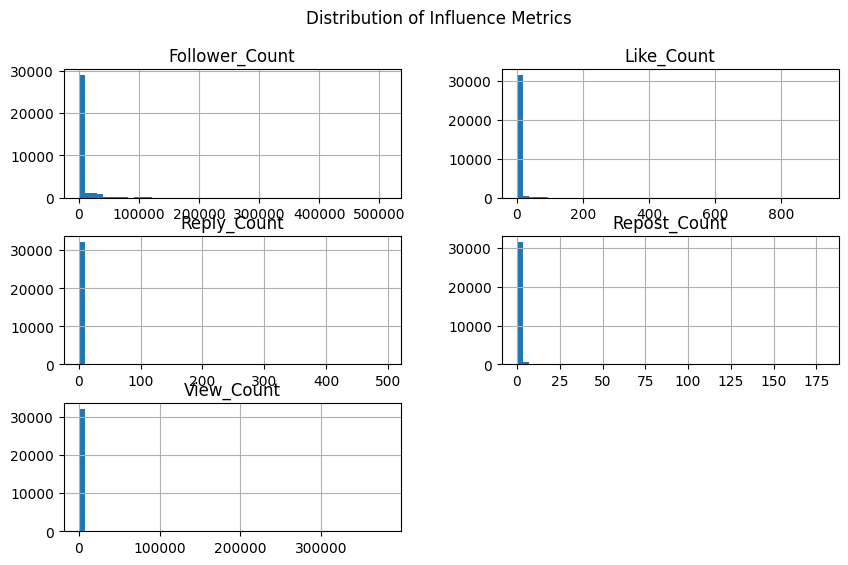

In [26]:
df[['Follower_Count','Like_Count', 'Reply_Count', 'Repost_Count', 'View_Count']].hist(bins=50, figsize=(10, 6))
plt.suptitle("Distribution of Influence Metrics")
plt.show()

looking at the distributions it seems as if there are a lot of 0's and very not

Checking Distributions

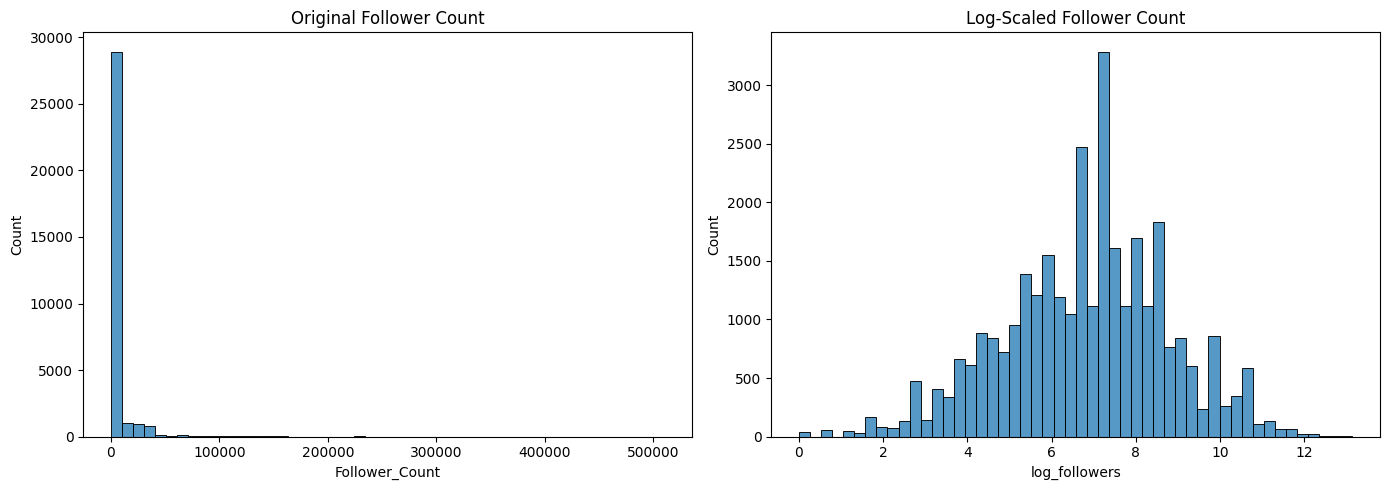

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df['log_followers'] = np.log1p(df['Follower_Count'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw follower count
sns.histplot(df['Follower_Count'], bins=50, ax=axes[0])
axes[0].set_title("Original Follower Count")

# Log-scaled follower count
sns.histplot(df['log_followers'], bins=50, ax=axes[1])
axes[1].set_title("Log-Scaled Follower Count")

plt.tight_layout()
plt.show()


In [27]:
engagement_cols = ['Follower_Count','Like_Count', 'Reply_Count', 'Repost_Count', 'View_Count']

# Count how many values are 0 in each column
zero_counts = df[engagement_cols].apply(lambda col: (col == 0).sum())

print("Number of zeros in each column:")
print(zero_counts)

Number of zeros in each column:
Follower_Count       37
Like_Count        15325
Reply_Count       22133
Repost_Count      23317
View_Count        16054
dtype: int64


Note that there is quite a bit of 0's in these columns. Either we should log transform them and see (which we will) but otherwise, we can also try to use models that are robust against skewness as there really is a lot of 0s. But first, let us try to see if there are any posts that consistently have no engagement, as it could indicate that it is a bot.


In [70]:
# Rows where engagement metrics are 0
zero_engagement_posts = df[df[engagement_cols].eq(0).all(axis=1)]

# Rows where engagmeent metrics other than follower count is 0.
metrics = ['Like_Count', 'Reply_Count', 'Repost_Count', 'View_Count']
zero_engagement_followers = df[df[metrics].eq(0).all(axis=1)]

print(f"Number of posts with zero engagement across all metrics: {len(zero_engagement_posts)}")
print(f"Number of posts with zero engagement across engagement metrics: {len(zero_engagement_followers)}")

# Note we look also because bots can buy followers.


Number of posts with zero engagement across all metrics: 9
Number of posts with zero engagement across engagement metrics: 4946


In [74]:
df_filtered = df[~df[engagement_cols].eq(0).all(axis=1)].copy()

In [76]:
df_filtered.to_csv("/content/drive/MyDrive/Masters Thesis/Colab notebook/clean_train.csv")

In [29]:
zero_engagement_by_author = zero_engagement_posts['Author_Handle'].value_counts()
follower_engagement_by_author = zero_engagement_followers['Author_Handle'].value_counts()

print("Top authors with most zero-engagement posts:")
print(zero_engagement_by_author.head(10))

print("Top authors with most zero-engagement posts (excluding followers):")
print(follower_engagement_by_author.head(10))

Top authors with most zero-engagement posts:
Author_Handle
Chongwk5           1
Crypto_Blondes     1
RishabhaDoshi      1
SpXstructural      1
crypto_twerk       1
funpredict         1
gogostox           1
investors_light    1
moneylead_yt       1
Name: count, dtype: int64
Top authors with most zero-engagement posts (excluding followers):
Author_Handle
SP500_Dow          344
InvariantPersp1    163
SteelTrades        143
quant_guy          142
TheFortuneTell5    113
samitrading1       108
GrandSuperCycle     76
FXCM_MarketData     74
John_Papadak        73
Dax30T              62
Name: count, dtype: int64


In [30]:
# Total posts per author
total_posts_per_author = df['Author_Handle'].value_counts()

# Zero-engagement posts per author
zero_ratio = (zero_engagement_by_author / total_posts_per_author).sort_values(ascending=False).fillna(0) * 100

# without followers
zero_ratio_wo_followers = (follower_engagement_by_author / total_posts_per_author).sort_values(ascending=False).fillna(0) * 100

print("Authors with the highest % of zero-engagement posts:")
print(zero_ratio.head(10))

print("Authors with the highest % of zero-engagement posts (excluding followers):")
print(zero_ratio_wo_followers.head(10))

Authors with the highest % of zero-engagement posts:
Author_Handle
Chongwk5           100.0
Crypto_Blondes     100.0
RishabhaDoshi      100.0
SpXstructural      100.0
crypto_twerk       100.0
funpredict         100.0
gogostox           100.0
investors_light    100.0
moneylead_yt       100.0
021Investment        0.0
Name: count, dtype: float64
Authors with the highest % of zero-engagement posts (excluding followers):
Author_Handle
zzlatko_zz         100.0
0x99percentdown    100.0
wincreaseteam      100.0
whunterknight      100.0
whopitapp          100.0
whitepaperinc      100.0
whatsup1246        100.0
vmacc317           100.0
vitalijus          100.0
ARSBBS             100.0
Name: count, dtype: float64


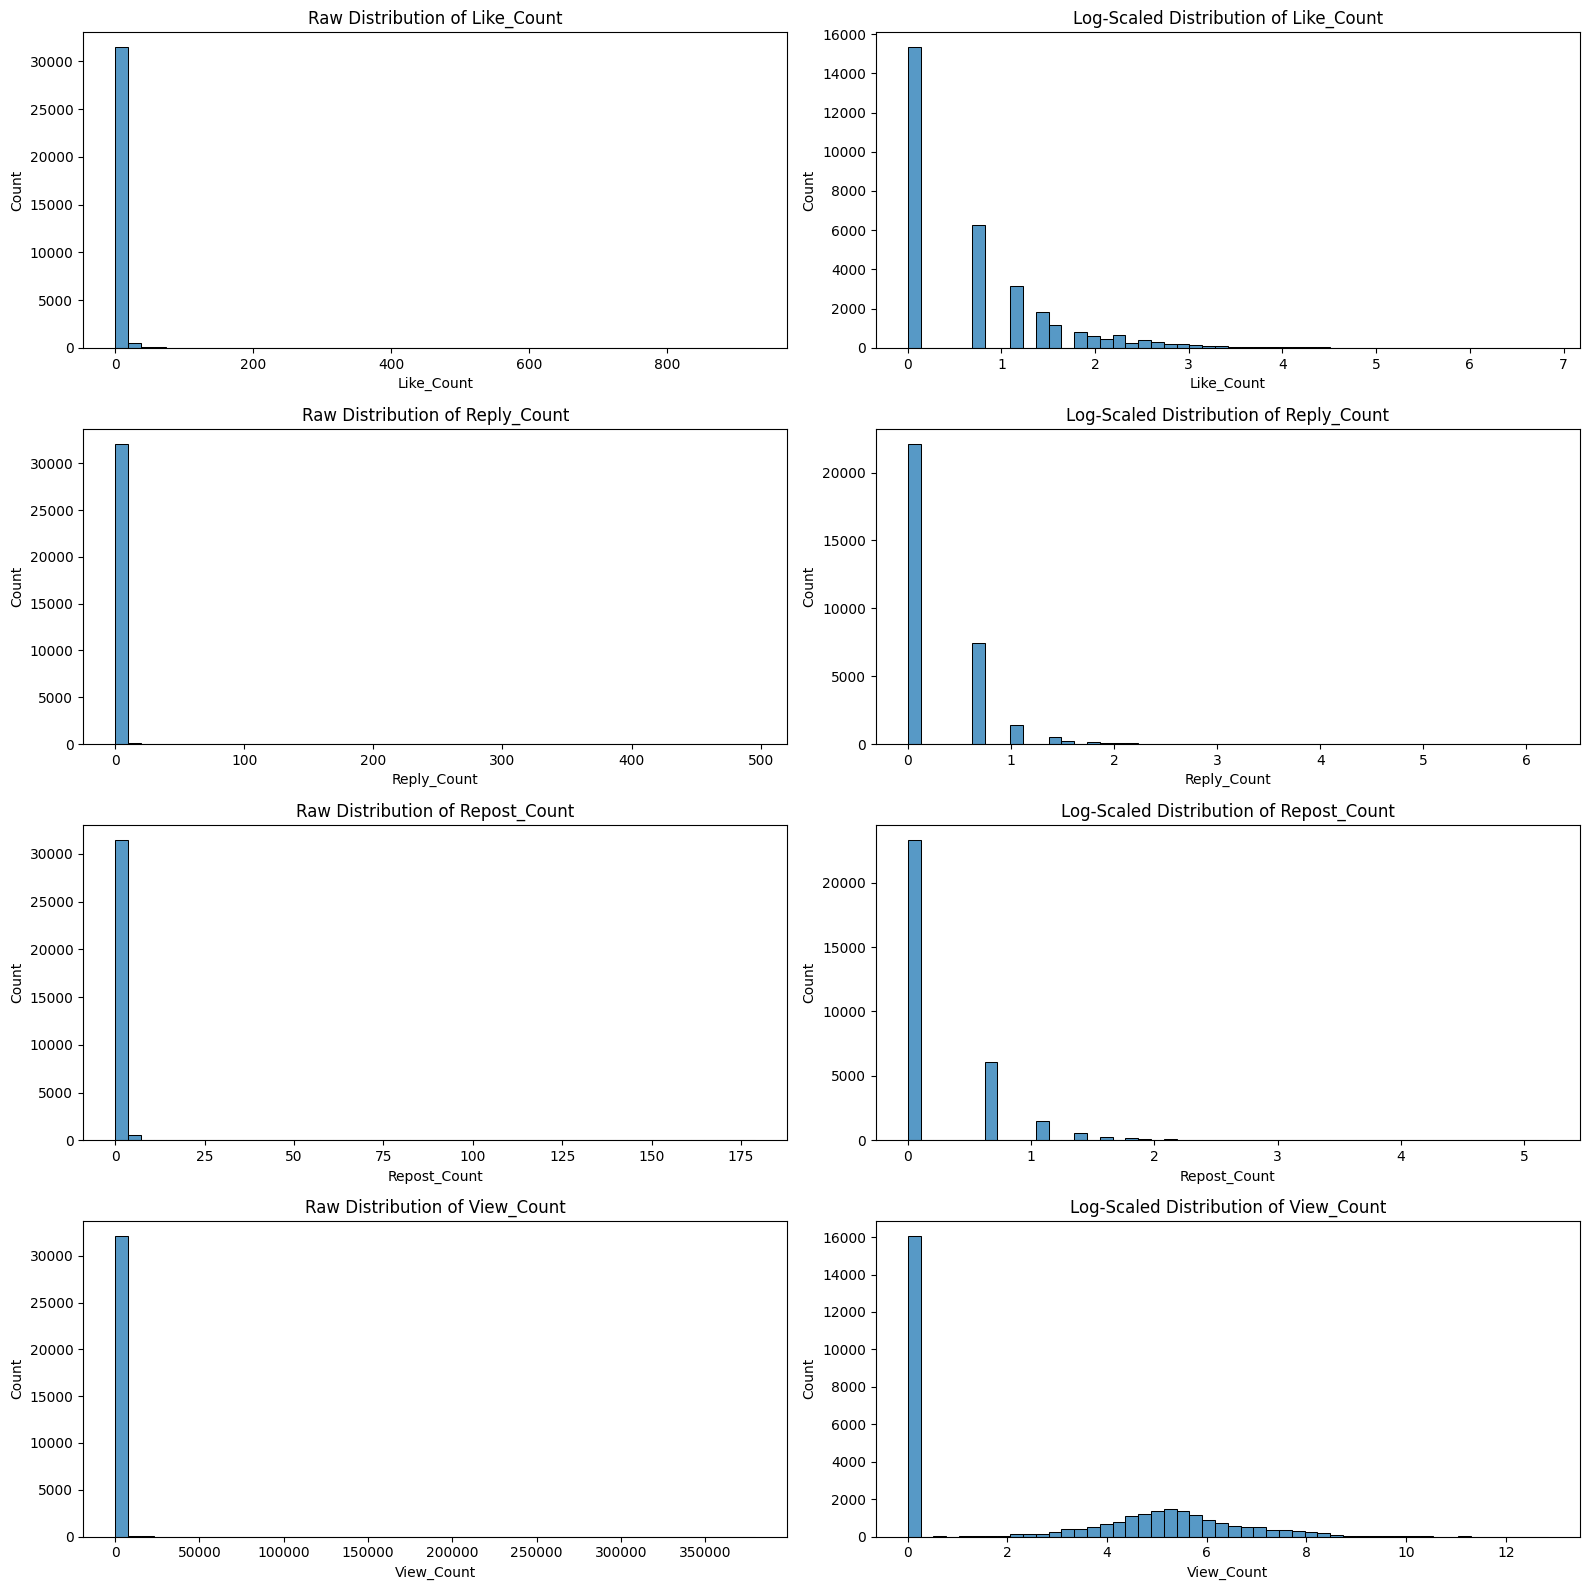

In [31]:
engagement_cols = ['Like_Count', 'Reply_Count', 'Repost_Count', 'View_Count']

fig, axes = plt.subplots(4, 2, figsize=(16, 16))

for i, col in enumerate(engagement_cols):
    # Raw histogram
    sns.histplot(df[col], bins=50, ax=axes[i, 0])
    axes[i, 0].set_title(f"Raw Distribution of {col}")

    # Log-transformed histogram
    log_data = np.log1p(df[col])  # log1p handles zeros safely
    sns.histplot(log_data, bins=50, ax=axes[i, 1])
    axes[i, 1].set_title(f"Log-Scaled Distribution of {col}")

plt.tight_layout()
plt.show()



Note, that even with log transformation, there are a lot of 0s. This indicates that perhaps there is not really a lot of engagement in the posts. based on the statsitics we saw earlier it definitely seemed to be the case. We will see how to handle this and test the correlations of multiple variables...

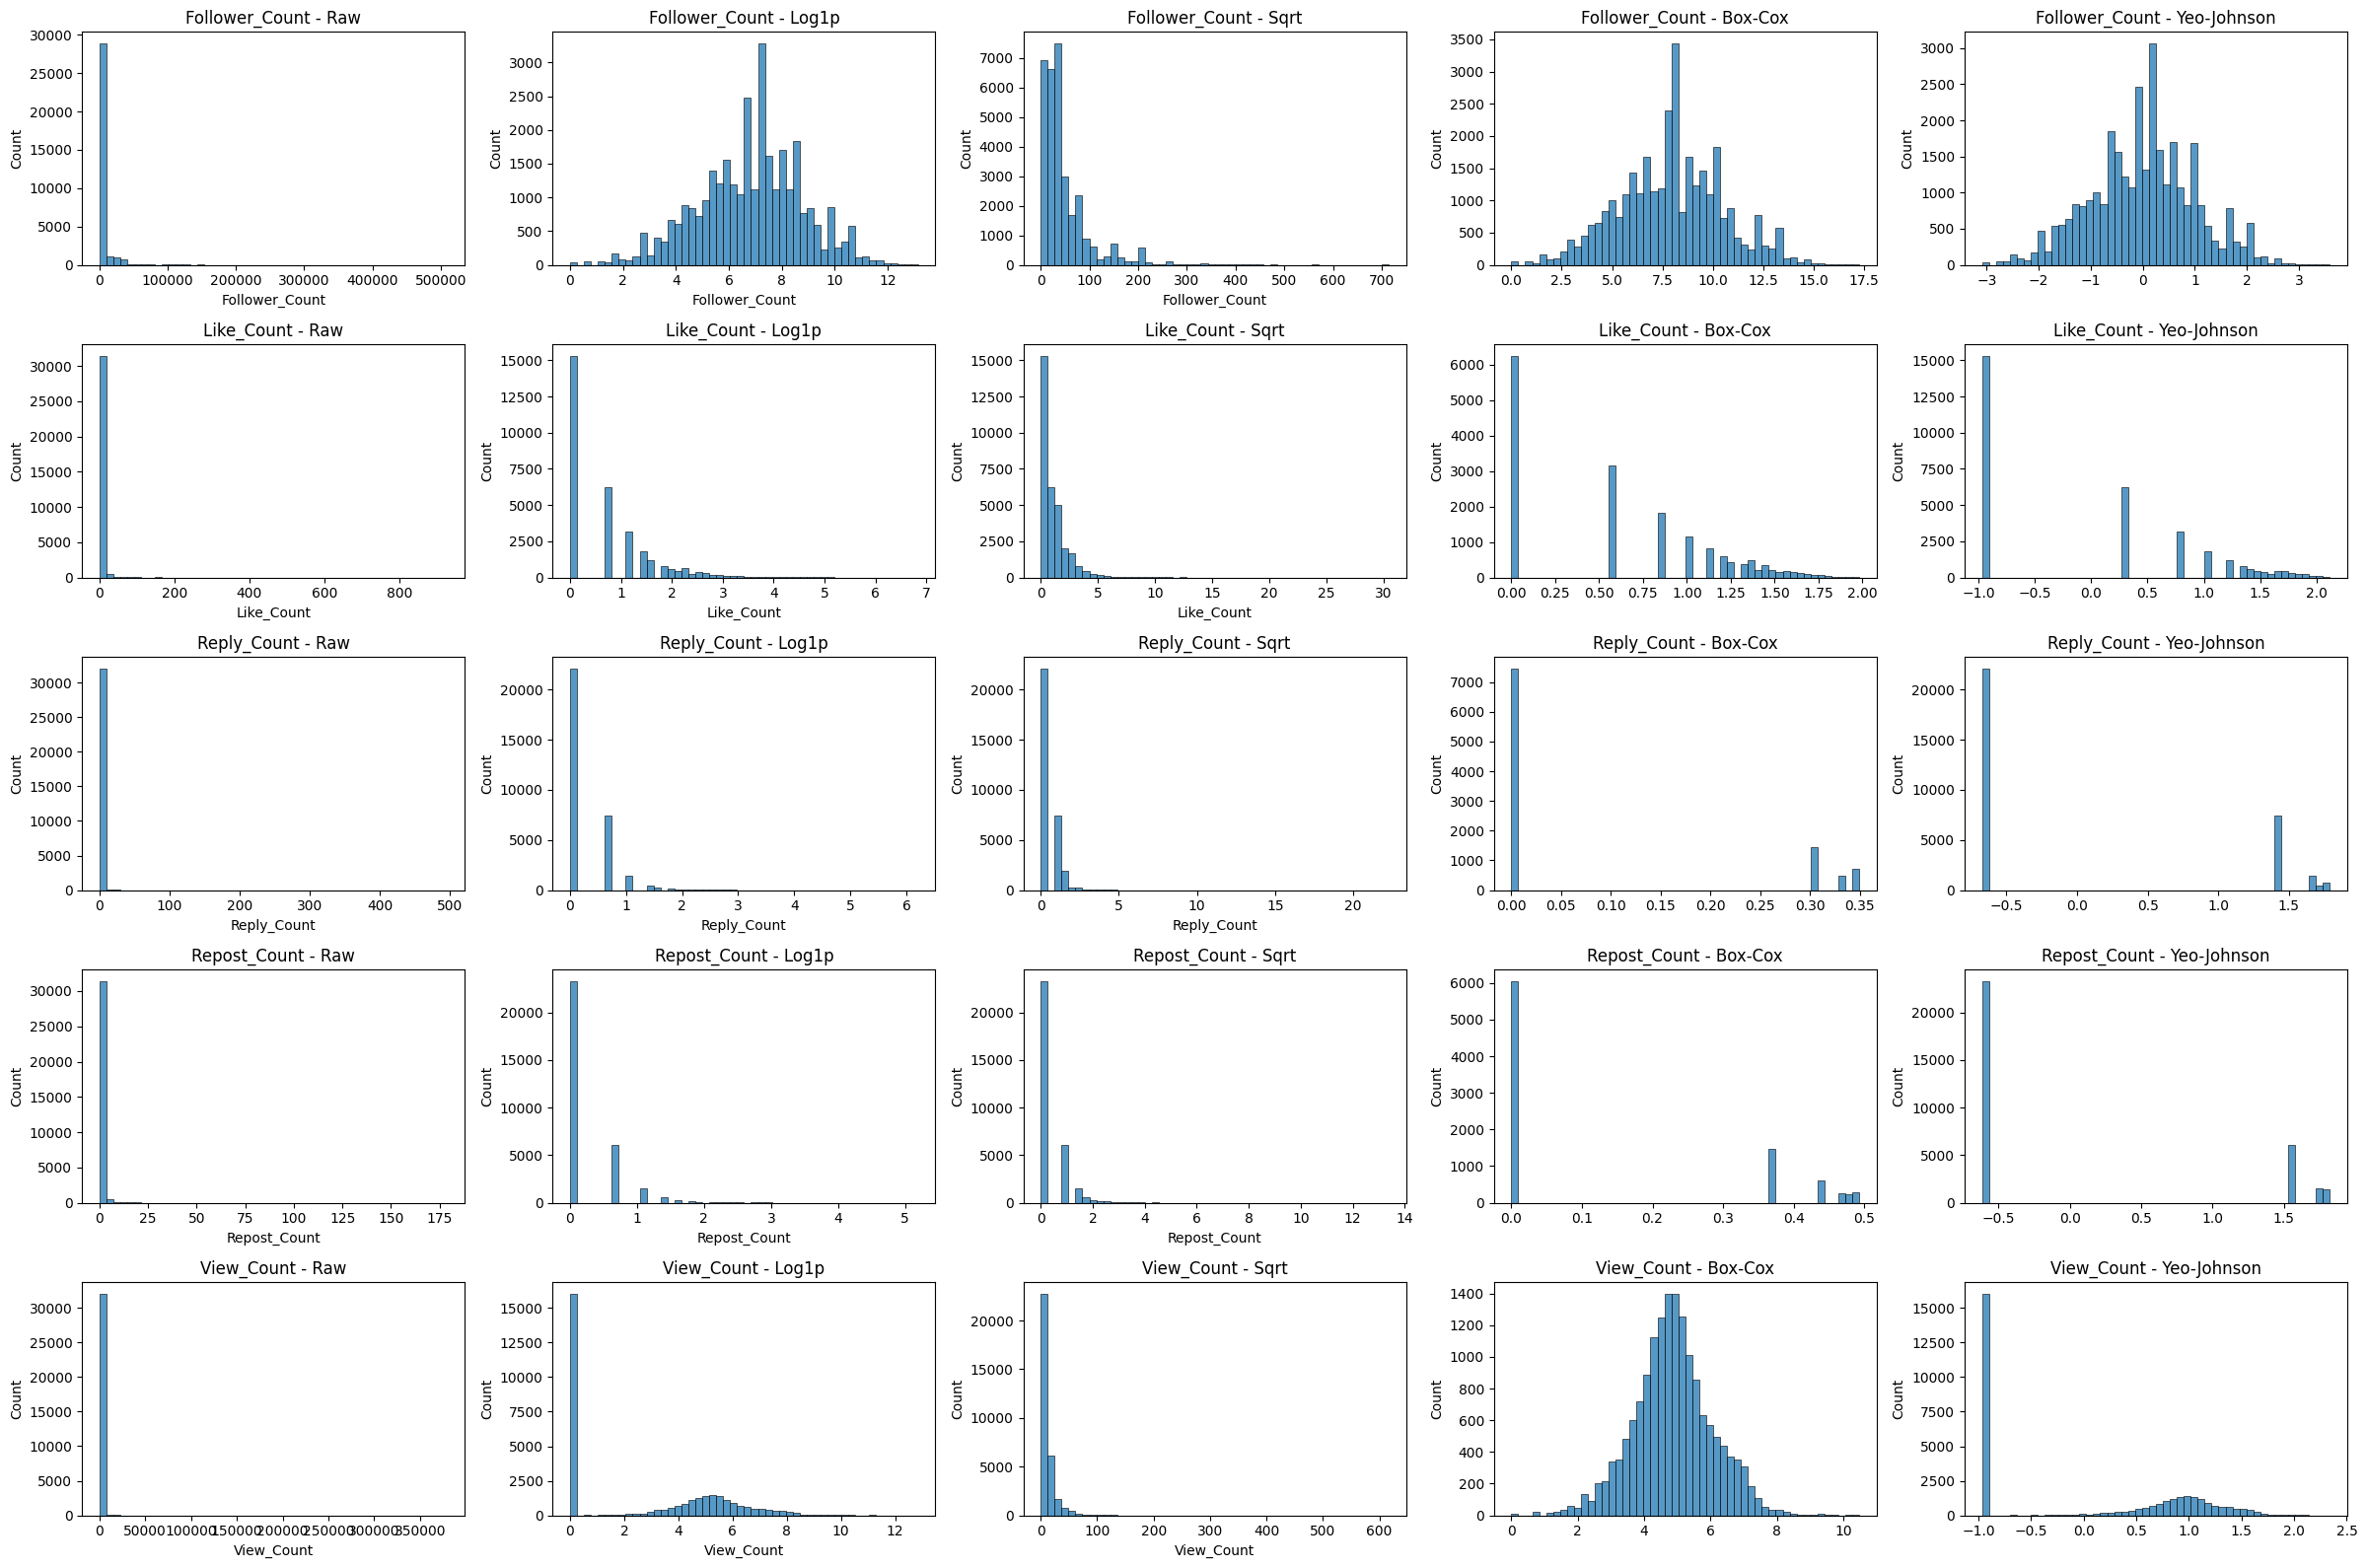

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox

engagement_cols = ['Follower_Count','Like_Count', 'Reply_Count', 'Repost_Count', 'View_Count']

fig, axes = plt.subplots(len(engagement_cols), 5, figsize=(24, 16))
transform_names = ['Raw', 'Log1p', 'Sqrt', 'Box-Cox', 'Yeo-Johnson']

for i, col in enumerate(engagement_cols):
    col_data = df[col].copy()

    # Raw
    sns.histplot(col_data, bins=50, ax=axes[i, 0])
    axes[i, 0].set_title(f"{col} - Raw")

    # Log1p
    log1p_data = np.log1p(col_data)
    sns.histplot(log1p_data, bins=50, ax=axes[i, 1])
    axes[i, 1].set_title(f"{col} - Log1p")

    # Sqrt
    sqrt_data = np.sqrt(col_data)
    sns.histplot(sqrt_data, bins=50, ax=axes[i, 2])
    axes[i, 2].set_title(f"{col} - Sqrt")

    # Box-Cox (only works for positive values)
    try:
        boxcox_data, _ = boxcox(col_data[col_data > 0])
        sns.histplot(boxcox_data, bins=50, ax=axes[i, 3])
        axes[i, 3].set_title(f"{col} - Box-Cox")
    except:
        axes[i, 3].set_visible(False)

    # Yeo-Johnson
    try:
        pt = PowerTransformer(method='yeo-johnson')
        yeojohnson_data = pt.fit_transform(col_data.values.reshape(-1, 1))
        sns.histplot(yeojohnson_data.flatten(), bins=50, ax=axes[i, 4])
        axes[i, 4].set_title(f"{col} - Yeo-Johnson")
    except:
        axes[i, 4].set_visible(False)

# Adjust layout
for ax in axes.flat:
    if ax:
        ax.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()


In [34]:
from scipy.stats import skew, kurtosis

for col in engagement_cols:
    print(f"\n{col}")
    raw = df[col].dropna()
    log1p_val = np.log1p(raw)
    sqrt_val = np.sqrt(raw)

    # Drop 0s for Box-Cox
    boxcox_val = boxcox(raw[raw > 0])[0]
    yeo_val = PowerTransformer(method='yeo-johnson').fit_transform(raw.values.reshape(-1, 1)).flatten()

    for name, series in zip(['Raw', 'Log1p', 'Sqrt', 'Box-Cox', 'Yeo-Johnson'],
                            [raw, log1p_val, sqrt_val, boxcox_val, yeo_val]):
        print(f"{name:<12} | Skew: {skew(series):>6.2f} | Kurtosis: {kurtosis(series):>6.2f}")



Follower_Count
Raw          | Skew:  11.06 | Kurtosis: 228.06
Log1p        | Skew:  -0.22 | Kurtosis:   0.04
Sqrt         | Skew:   2.97 | Kurtosis:  14.18
Box-Cox      | Skew:  -0.00 | Kurtosis:  -0.02
Yeo-Johnson  | Skew:  -0.00 | Kurtosis:  -0.04

Like_Count
Raw          | Skew:  29.95 | Kurtosis: 1334.49
Log1p        | Skew:   1.40 | Kurtosis:   2.21
Sqrt         | Skew:   3.87 | Kurtosis:  38.09
Box-Cox      | Skew:   0.21 | Kurtosis:  -1.26
Yeo-Johnson  | Skew:   0.34 | Kurtosis:  -1.41

Reply_Count
Raw          | Skew: 106.30 | Kurtosis: 15320.38
Log1p        | Skew:   2.07 | Kurtosis:   6.73
Sqrt         | Skew:   3.42 | Kurtosis:  53.06
Box-Cox      | Skew:   1.11 | Kurtosis:  -0.74
Yeo-Johnson  | Skew:   0.82 | Kurtosis:  -1.29

Repost_Count
Raw          | Skew:  32.58 | Kurtosis: 1475.90
Log1p        | Skew:   2.41 | Kurtosis:   8.94
Sqrt         | Skew:   3.66 | Kurtosis:  34.66
Box-Cox      | Skew:   0.83 | Kurtosis:  -1.23
Yeo-Johnson  | Skew:   1.01 | Kurtosis:  -0.96



In [ ]:
# Get unique Author_Handle
unique_handles = df['Author_Handle'].unique()

# Get unique X posts
unique_posts = df['X_Post'].unique()

# Get the frequency of posts by Author_Handle
post_count_by_handle = df['Author_Handle'].value_counts()

total_posts = len(df)

# Calculate the percentage of tweets for each Author_Handle
percentage_by_handle = (post_count_by_handle / total_posts) * 100


# Get the number of unique author handles
print(f"Number of unique handles: {len(unique_handles)}")
print(f"Number of unique X Posts: {len(unique_posts)}")
print(post_count_by_handle.head())

print("Percentage of posts by each Author_Handle:")
print(percentage_by_handle)

# Note in this dataset, some tweets come from the same author. namely cyberalgo, SP500_Dow, TheFortuneTell5, and CHARTISKING make up around 3% each.


Number of unique handles: 5085
Number of unique X Posts: 30208
Author_Handle
cyberalgo          1889
SP500_Dow          1487
InvariantPersp1     764
samitrading1        594
FXCM_MarketData     594
Name: count, dtype: int64
Percentage of posts by each Author_Handle:
Author_Handle
cyberalgo          5.785605
SP500_Dow          4.554364
InvariantPersp1    2.339969
samitrading1       1.819296
FXCM_MarketData    1.819296
                     ...   
kuntzxbt           0.003063
Crypt0pians        0.003063
crypto_burger7     0.003063
Prime_is_Back      0.003063
unclemungy         0.003063
Name: count, Length: 5085, dtype: float64


<ipython-input-22-c0052433efba>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_post_count.index, y=top_10_post_count.values, palette='viridis')


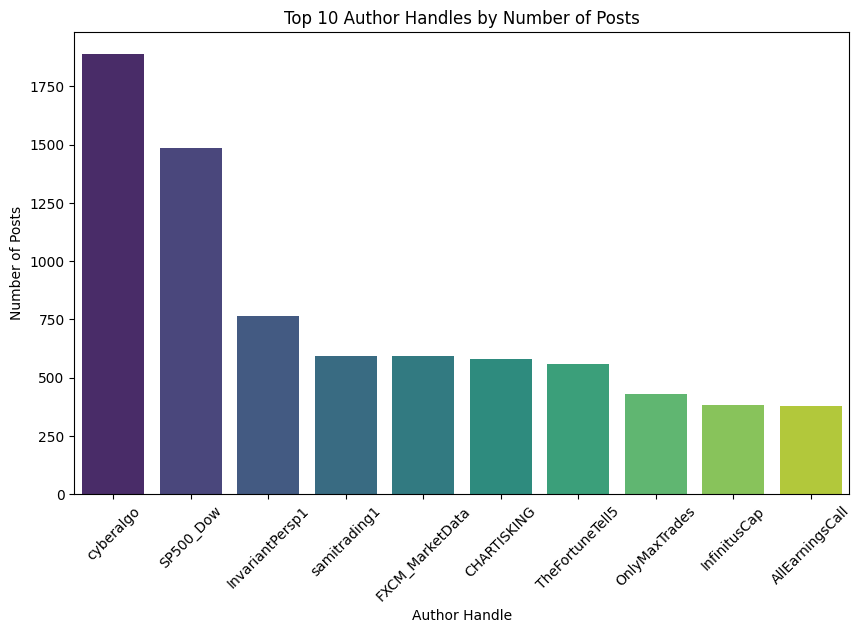

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 posters
top_10_post_count = post_count_by_handle.head(10)

# Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_post_count.index, y=top_10_post_count.values, palette='viridis')
plt.title('Top 10 Author Handles by Number of Posts')
plt.xlabel('Author Handle')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.show()

<Axes: xlabel='Prediction'>

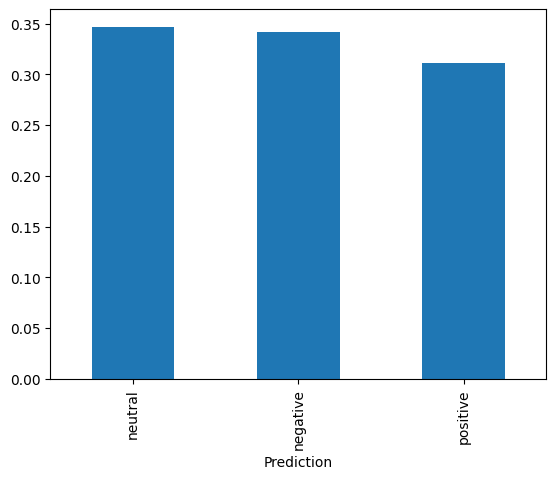

In [37]:
df['Prediction'].value_counts(normalize=True).plot(kind='bar')

<Axes: xlabel='Date'>

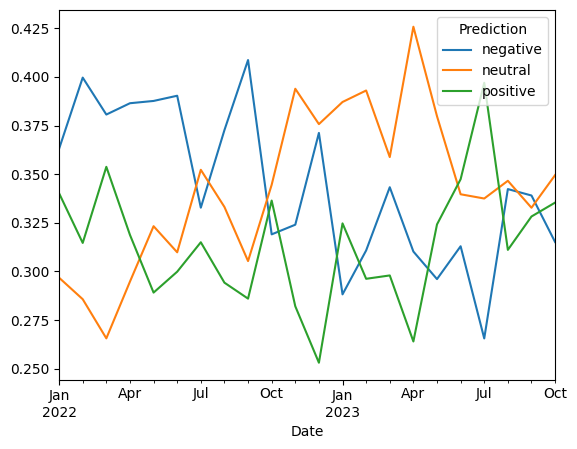

In [39]:
df.groupby(df['Date'].dt.to_period('M'))['Prediction'].value_counts(normalize=True).unstack().plot()


<Axes: xlabel='Prediction'>

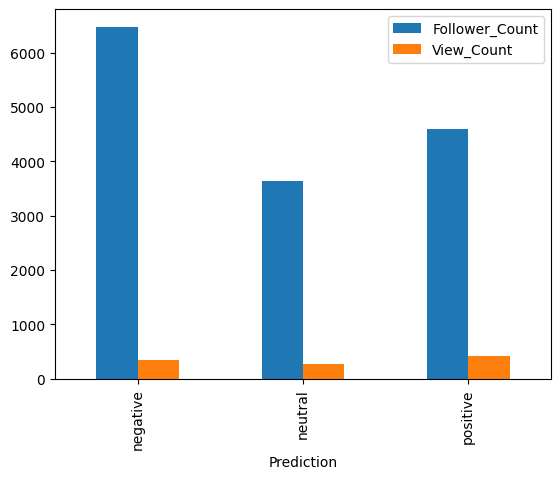

In [45]:
df.groupby('Prediction')[['Follower_Count','View_Count']].mean().plot(kind='bar')

<Axes: xlabel='Prediction'>

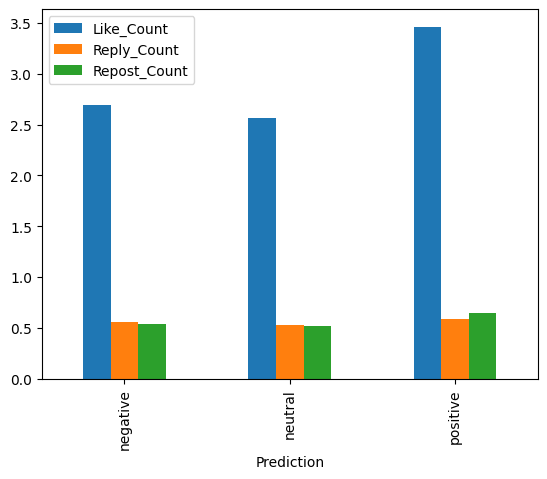

In [46]:
df.groupby('Prediction')[['Like_Count', 'Reply_Count', 'Repost_Count']].mean().plot(kind='bar')

In [47]:
from scipy.stats import kruskal

for col in ['Like_Count', 'View_Count', 'Reply_Count', 'Repost_Count']:
    groups = [df[df['Prediction'] == label][col] for label in df['Prediction'].unique()]
    stat, p = kruskal(*groups)
    print(f"{col}: p-value = {p:.4f}")


Like_Count: p-value = 0.0000
View_Count: p-value = 0.0000
Reply_Count: p-value = 0.0000
Repost_Count: p-value = 0.0000


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


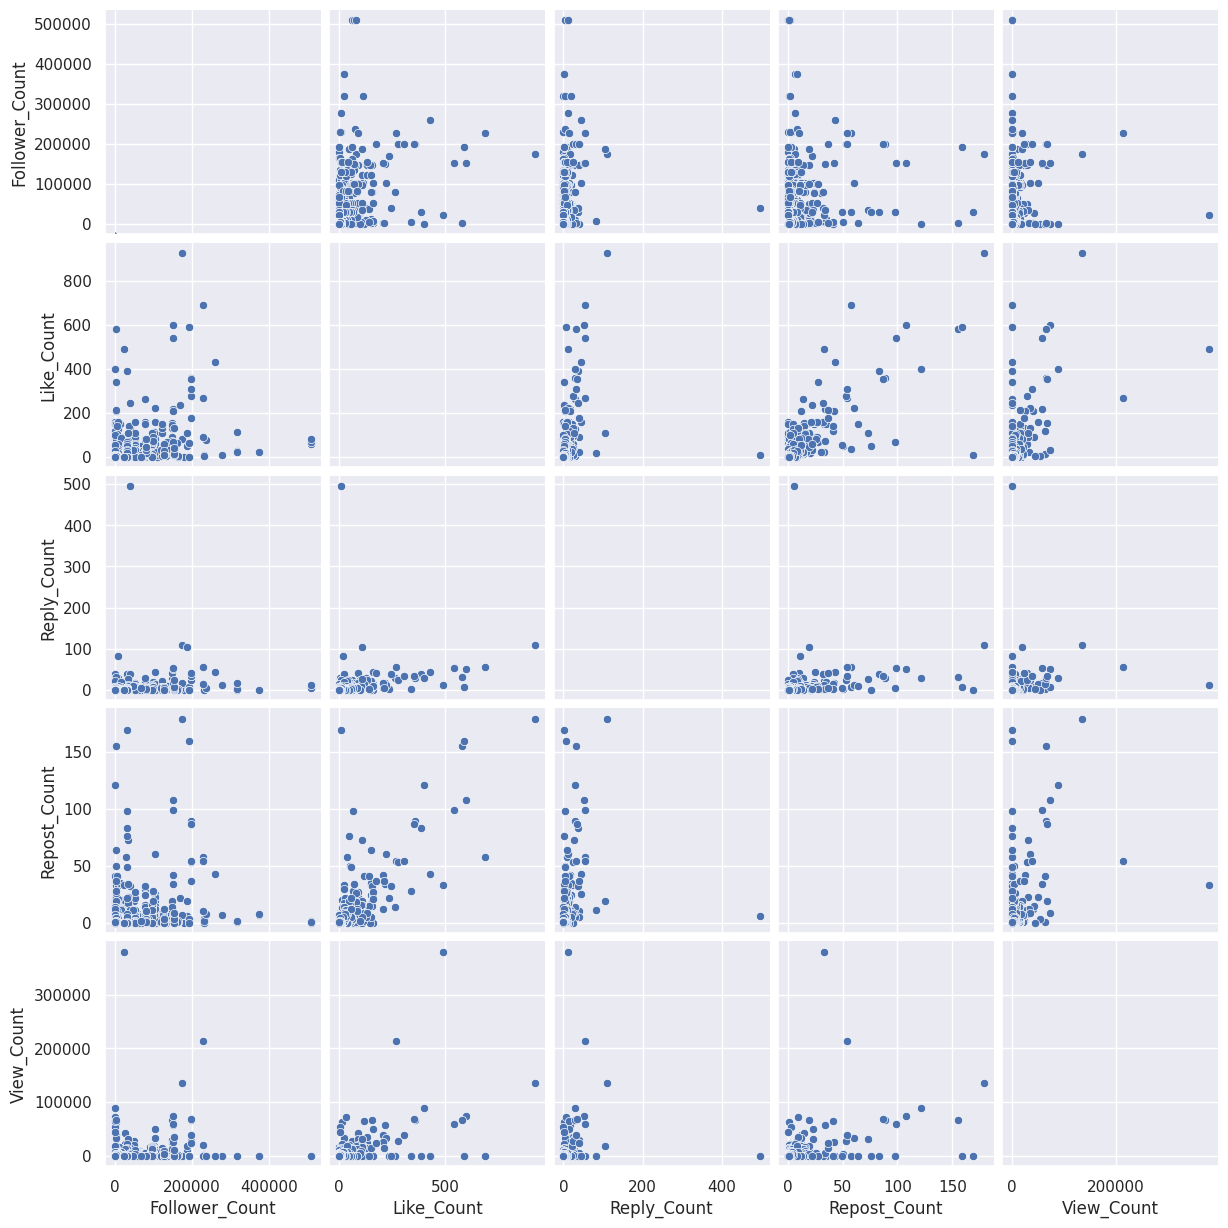

In [50]:
#scatterplot

engagement_cols = ['Follower_Count','Like_Count', 'Reply_Count', 'Repost_Count', 'View_Count']

sns.set()
sns.pairplot(df[engagement_cols], size = 2.5)
plt.show();

<Axes: >

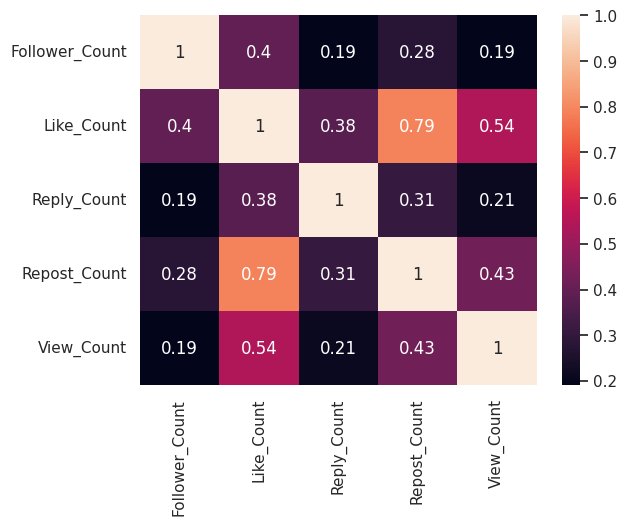

In [51]:
sns.heatmap(df[['Follower_Count','Like_Count', 'Reply_Count', 'Repost_Count', 'View_Count']].corr(), annot=True)

In [53]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = df[['Like_Count', 'View_Count', 'Reply_Count', 'Repost_Count']]
X = add_constant(X)  # Needed for VIF
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_df)


        feature       VIF
0         const  1.053942
1    Like_Count  3.217550
2    View_Count  1.419078
3   Reply_Count  1.165065
4  Repost_Count  2.653183


In [59]:
engagement_cols = ['Like_Count', 'Reply_Count', 'Repost_Count', 'View_Count', 'Follower_Count']
df['Sentiment_Numeric'] = df['Prediction'].map({'negative': -1, 'neutral': 0, 'positive': 1})  # adjust if needed

correlations = df[engagement_cols + ['Sentiment_Numeric']].corr()
print(correlations['Sentiment_Numeric'].sort_values(ascending=False))


Sentiment_Numeric    1.000000
Like_Count           0.021823
Repost_Count         0.014009
View_Count           0.009987
Reply_Count          0.003603
Follower_Count      -0.053400
Name: Sentiment_Numeric, dtype: float64


# Applying bots to test and validation data

In [77]:
import pandas as pd

# Bubs
val = pd.read_excel('/content/drive/My Drive/Masters Thesis/Colab notebook/validation_data.xlsx')
test = pd.read_excel('/content/drive/My Drive/Masters Thesis/Colab notebook/test_data.xlsx')

import pandas as pd
from rapidfuzz import fuzz

# Set time window and similarity threshold
TIME_WINDOW = pd.Timedelta(minutes=5)
FUZZY_THRESHOLD = 90  # 0-100

# Pre-clean text (optional but recommended)
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    return text.strip()

val['post_text'] = val['X_Post'].apply(clean_text)
val = val.sort_values(by=['Author_Handle', 'Date'])

# Flag duplicates
val['is_time_duplicate'] = False

for user_id, group in val.groupby('Author_Handle'):
    group = group.reset_index()
    last_text = None
    last_time = None

    for i in range(len(group)):
        current_time = group.loc[i, 'Date']
        current_text = group.loc[i, 'post_text']

        if last_time is not None and (current_time - last_time) <= TIME_WINDOW:
            similarity = fuzz.ratio(current_text, last_text)
            if similarity >= FUZZY_THRESHOLD:
                val.loc[group.loc[i, 'index'], 'is_time_duplicate'] = True
        else:
            last_time = current_time
            last_text = current_text

num_duplicates = val['is_time_duplicate'].sum()
print(f"Number of time-sensitive duplicates: {num_duplicates}")

val = val[~val['is_time_duplicate']].copy()
val.drop(columns=['is_time_duplicate'], inplace=True)

print(f"Remaining rows after removing duplicates: {len(val)}")

Number of time-sensitive duplicates: 42
Remaining rows after removing duplicates: 7898


In [79]:
val_filtered = val[~val[engagement_cols].eq(0).all(axis=1)].copy()
val_filtered.shape

(7898, 14)

In [80]:
val_filtered.to_csv("/content/drive/MyDrive/Masters Thesis/Colab notebook/clean_val.csv")

In [83]:
# Set time window and similarity threshold
TIME_WINDOW = pd.Timedelta(minutes=5)
FUZZY_THRESHOLD = 90  # 0-100

# Pre-clean text (optional but recommended)
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    return text.strip()

test['post_text'] = test['X_Post'].apply(clean_text)
test = test.sort_values(by=['Author_Handle', 'Date'])

# Flag duplicates
test['is_time_duplicate'] = False

for user_id, group in test.groupby('Author_Handle'):
    group = group.reset_index()
    last_text = None
    last_time = None

    for i in range(len(group)):
        current_time = group.loc[i, 'Date']
        current_text = group.loc[i, 'post_text']

        if last_time is not None and (current_time - last_time) <= TIME_WINDOW:
            similarity = fuzz.ratio(current_text, last_text)
            if similarity >= FUZZY_THRESHOLD:
                test.loc[group.loc[i, 'index'], 'is_time_duplicate'] = True
        else:
            last_time = current_time
            last_text = current_text

num_duplicates = test['is_time_duplicate'].sum()
print(f"Number of time-sensitive duplicates: {num_duplicates}")

test = test[~test['is_time_duplicate']].copy()
test.drop(columns=['is_time_duplicate'], inplace=True)

print(f"Remaining rows after removing duplicates: {len(test)}")

Number of time-sensitive duplicates: 0
Remaining rows after removing duplicates: 7517


In [84]:
test_filtered = test[~test[engagement_cols].eq(0).all(axis=1)].copy()
test_filtered.shape

(7516, 14)

In [86]:
test_filtered.to_csv("/content/drive/MyDrive/Masters Thesis/Colab notebook/clean_test.csv")

In [ ]:
# Loading in saved final dataset without going through previous data exploration
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

# Sebs
final_data = pd.read_excel('/content/drive/MyDrive/Masters Thesis/Colab notebook/Sentiment analysis/RoBERTa_sentiment_preds_reply.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Markdown, HTML

# 1. Convert 'Date' column to datetime
final_data['Date'] = pd.to_datetime(final_data['Date'])

# 2. Get the number of tweets per day
tweets_per_day = final_data.groupby(final_data['Date'].dt.date).size()

# 3. Top 10 days with the highest number of tweets
top_days = tweets_per_day.sort_values(ascending=False).head(10)

# Convert to a DataFrame so we can merge columns easily
top_days_df = top_days.reset_index()
top_days_df.columns = ['Date', 'X_Post_Count']

# 4. Filter original data to only those top 10 days
top_data = final_data[final_data['Date'].dt.date.isin(top_days_df['Date'])]

# 5. Group by date and sentiment label
sentiment_counts = top_data.groupby([top_data['Date'].dt.date, 'Prediction']).size().unstack(fill_value=0)

# -- Rename sentiment columns (remove column name "Prediction") --
sentiment_counts.columns.name = None
sentiment_counts.rename(columns={
    'negative': 'Negative',
    'neutral': 'Neutral',
    'positive': 'Positive'
}, inplace=True)

# -- Reindex so rows match the top 10 dates --
sentiment_counts_ordered = sentiment_counts.reindex(top_days_df['Date'])

# -- Keep the 'Date' as index but remove its name (so there's only one header row) --
sentiment_counts_ordered.index.name = None

# -- Incorporate Tweet_Count as a new column in the sentiment_counts_ordered DataFrame --
#    We'll align rows by matching the 'Date' index from sentiment_counts_ordered
#    with the 'Date' column from top_days_df.
sentiment_counts_ordered['X_Post_Count'] = top_days_df.set_index('Date').reindex(
    sentiment_counts_ordered.index
)['X_Post_Count']

# (Optional) Reorder columns so Tweet_Count is at the end (Negative, Neutral, Positive, Tweet_Count)
sentiment_counts_ordered = sentiment_counts_ordered[['Negative', 'Neutral', 'Positive', 'X_Post_Count']]

# ---- Create separate output widgets for the plot and the single combined table ----
plot_output = widgets.Output()
sentiment_output = widgets.Output()

# ---- Plot Output ----
with plot_output:
    fig, ax = plt.subplots(figsize=(8, 5))
    tweets_per_day.plot(ax=ax)
    ax.set_title('Posts per Day')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of posts')
    plt.xticks(rotation=45, ha='right')  # Rotate date labels for readability
    plt.tight_layout()
    plt.show()

# ---- Sentiment & Tweet Counts Output ----
with sentiment_output:
    # Using HTML to create a centered title for the table.
    display(HTML("<h3 style='text-align: center;'>Sentiment counts & X post count</h3>"))
    # Now display your combined table
    display(sentiment_counts_ordered)

# ---- Arrange the two outputs side by side ----
box_layout = widgets.Layout(
    display='flex',
    flex_flow='row',
    align_items='flex-start',
    width='100%'
)
box = widgets.HBox([plot_output, sentiment_output], layout=box_layout)
display(box)


# Explanation of highest number of posts
**Positive sentiment**

The single day with the highest amount of posts on X containing the #SPX500 parameter is November 10th, 2024. This is a significant day as it follows just after the election of American president Donald Trump. This news is fueled by the Trump's presidential election victory, where investor optimism rose to new heights due to positive expectations of pro-business policies, including corporate tax cuts and deregulation. This positive sentiment made the S&P 500 sore to new heights, closing at almost 6000 usd, which was a record closing price for that time.

As seen in the data above, these news correspond with the high amount of positive labels, compared to the negatively labeled sentiment.

**Negative sentiment**

Reversely it is apparent that another top 10 day with the highest number of X_posts, contains a lot of negative labels. On september 23, 2022, the S&P 500 index experienced a significant decline, down 1,7% from the previous day.

In [ ]:
final_data.columns

Index(['Author_Handle', 'Date', 'X_Post', 'Reply_Count', 'Repost_Count',
       'Like_Count', 'View_Count', 'Follower_Count', 'Verified_Status',
       'Prediction', 'Confidence', 'Replying_to'],
      dtype='object')

There are some links in the X_Posts, we remove this so it does not disturb the sentiment analysis.

In [ ]:
# Remove links from 'X_Post' column
# final_data['X_Post'] = final_data['X_Post'].str.replace(r'http\S+', '', regex=True)

<ipython-input-97-624ded4847ae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['X_Post'] = final_data['X_Post'].str.replace(r'http\S+', '', regex=True)


In [ ]:
final_data.to_excel("/content/drive/My Drive/Masters Thesis/Colab notebook/final_no_links.xlsx", index=False)


KeyboardInterrupt: 

In [ ]:
final_data.columns
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48140 entries, 0 to 48139
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Author_Handle    48140 non-null  object        
 1   Date             48140 non-null  datetime64[ns]
 2   X_Post           48140 non-null  object        
 3   Reply_Count      48140 non-null  int64         
 4   Repost_Count     48140 non-null  int64         
 5   Like_Count       48140 non-null  int64         
 6   View_Count       48140 non-null  int64         
 7   Follower_Count   48140 non-null  int64         
 8   Verified_Status  48140 non-null  int64         
 9   Prediction       48140 non-null  object        
 10  Confidence       48140 non-null  float64       
 11  Replying_to      48140 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 4.1+ MB


# Looking into influence metrics

## Loading in libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Descriptive Statistics
**1.** Statistical summary of numeric columns (reply, like, follower count, etc.).

**2.** Frequency counts of categorical columns (e.g., Verified_Status, Prediction).

**3.** Sentiment distribution (count how many positive, negative, neutral).

In [ ]:
# Defining numeric columns
numeric_cols = ['Reply_Count', 'Repost_Count', 'Like_Count', 'View_Count', 'Follower_Count']

# Summary of numeric columns with 2 decimal places
display(final_data[numeric_cols].describe().style.format("{:.2f}"))  # Format with 2 decimals

# Count of Verified_Status
display(final_data['Verified_Status'].value_counts())

# Count of sentiment predictions
display(final_data['Prediction'].value_counts())

,Reply_Count,Repost_Count,Like_Count,View_Count,Follower_Count
count,48140.00,48140.00,48140.00,48140.00,48140.00
mean,0.54,0.59,2.98,486.94,4456.56
std,3.12,2.74,14.00,14879.32,13428.49
min,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,208.00
50%,0.00,0.00,1.00,81.00,930.00
75%,1.00,1.00,2.00,283.00,3100.00
max,496.00,179.00,1215.00,3198559.00,510000.00


,count
Verified_Status,
0,31947
1,16193


,count
Prediction,
neutral,17013
positive,16362
negative,14765


# Sentiment Analysis Exploration
**1.** Overall sentiment distribution across the entire dataset.

**2.** Time-trend of sentiment proportions.

**3.** Engagement metrics by sentiment (e.g., do positive tweets get more likes on average?).

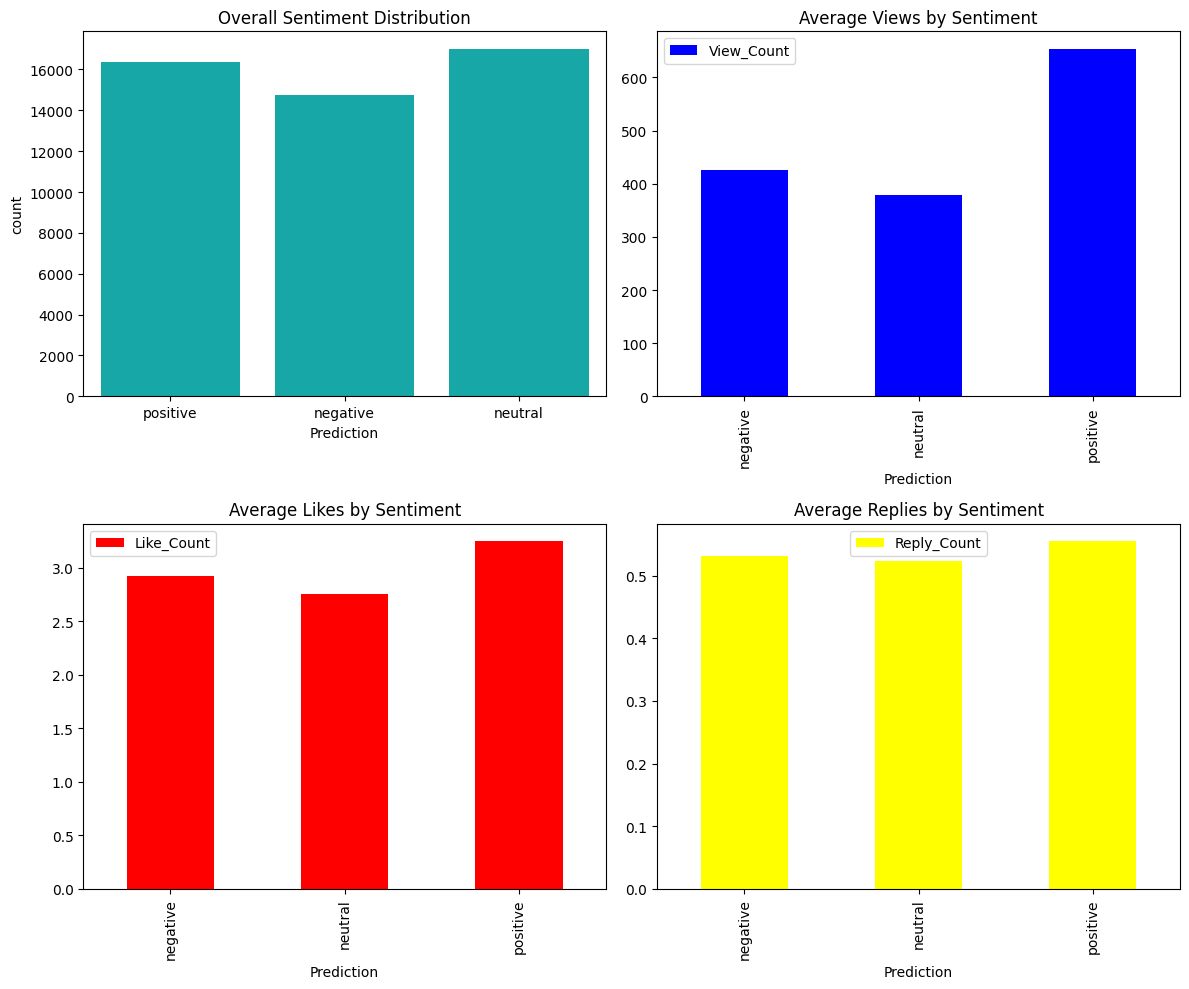

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Example data: uncomment and modify these lines if you need to create sample DataFrames.
# final_data = pd.DataFrame({
#     'Prediction': ['Positive', 'Negative', 'Neutral', 'Positive', 'Negative'],
# })
# df = pd.DataFrame({
#     'Prediction': ['Positive', 'Negative', 'Neutral', 'Positive', 'Negative'],
#     'View_Count': [100, 150, 200, 130, 160],
#     'Like_Count': [10, 15, 20, 13, 16],
#     'Reply_Count': [5, 8, 9, 7, 10]
# })

os.chdir('/content/drive/MyDrive/Masters Thesis/Colab notebook')

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Overall sentiment distribution
sns.countplot(x='Prediction', data=final_data, color='c', ax=axs[0, 0])
axs[0, 0].set_title('Overall Sentiment Distribution')

# Plot 2: Average view count by sentiment
final_data.groupby('Prediction')[['View_Count']].mean().plot(kind='bar', color='blue', ax=axs[0, 1])
axs[0, 1].set_title('Average Views by Sentiment')

# Plot 3: Average like count by sentiment
final_data.groupby('Prediction')[['Like_Count']].mean().plot(kind='bar', color='red', ax=axs[1, 0])
axs[1, 0].set_title('Average Likes by Sentiment')

# Plot 4: Average reply count by sentiment
final_data.groupby('Prediction')[['Reply_Count']].mean().plot(kind='bar', color='yellow', ax=axs[1, 1])
axs[1, 1].set_title('Average Replies by Sentiment')

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Save the combined figure to a single PNG file
plt.savefig('combined_plots.png')

# Optionally, display the combined figure
plt.show()


What you can deduce from the above is that posts with positive sentiment get more views and more likes than neutral and negative posts.

Reply count does not seem to be about the same, which can probably be attributed to the fact that very few posts have replies, making this data sparse.

# Textual Analysis
Tokenization and preprocessing of text in X_Post (remove punctuation, stopwords, etc.).

**1.** Word frequency or bigram/trigram analysis.

**2.** Word cloud of common words (separate by sentiment).

**3.** Topic modeling (e.g., using LDA) to see common topics among posts.

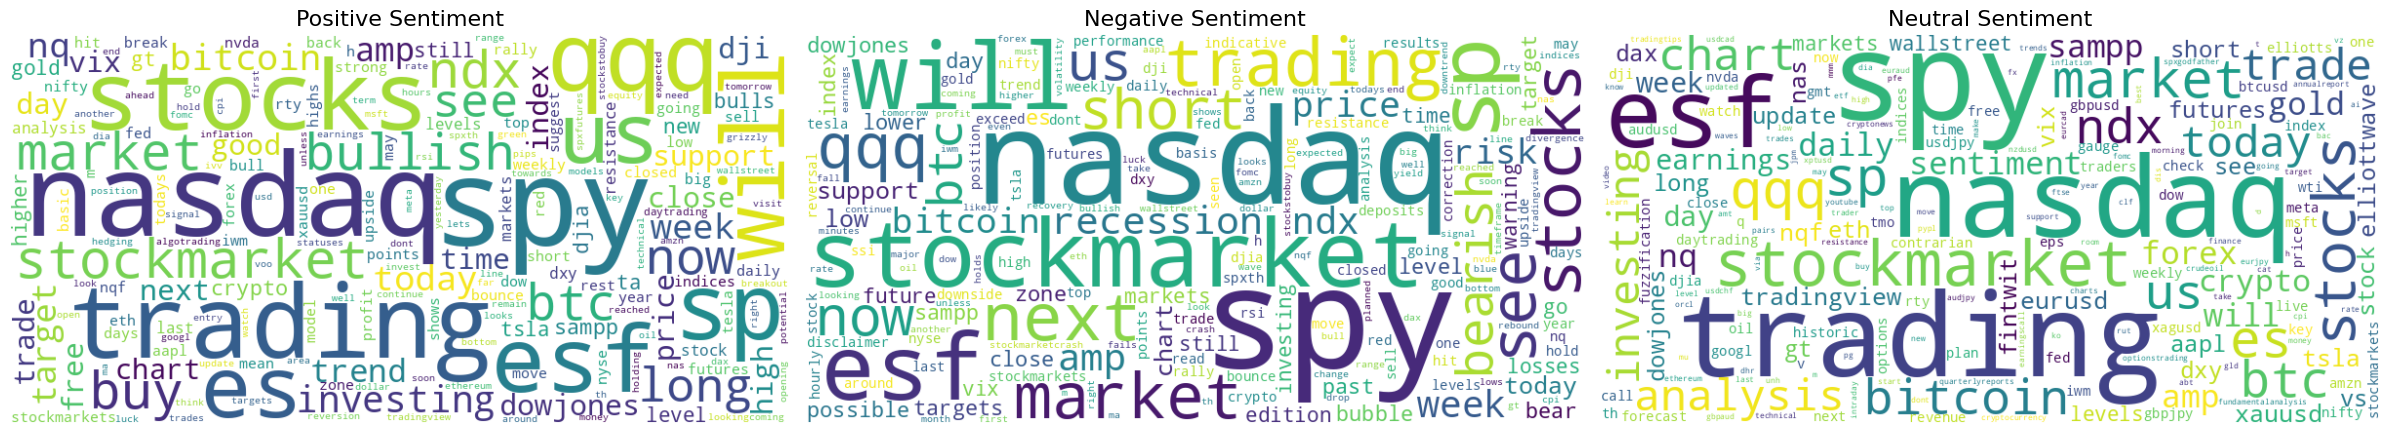

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import re

# Custom tokenizer
def tokenize(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
    return text.split()

# Custom stopwords – extend with domain-specific terms like 'spx'
custom_stopwords = STOPWORDS.union({'spx'})

# Function to get word frequency for a specific sentiment
def get_word_freq(dataframe, sentiment_label):
    sentiment_posts = dataframe[dataframe['Prediction'] == sentiment_label]['X_Post'].dropna().tolist()
    all_words = []
    for post in sentiment_posts:
        all_words.extend(tokenize(post))
    filtered_words = [word for word in all_words if word not in custom_stopwords]
    return Counter(filtered_words)

# Create a combined figure of word clouds for a list of sentiments and save as a PNG file
def create_combined_wordclouds(dataframe, sentiments=['positive', 'negative', 'neutral'], output_file='combined_wordclouds.png'):
    num_sentiments = len(sentiments)
    # Create a subplot with one row and as many columns as sentiment labels
    fig, axes = plt.subplots(1, num_sentiments, figsize=(8 * num_sentiments, 6))

    # When there is only one sentiment, ensure axes is iterable
    if num_sentiments == 1:
        axes = [axes]

    # Loop through each sentiment and create its corresponding word cloud
    for ax, sentiment in zip(axes, sentiments):
        freq = get_word_freq(dataframe, sentiment)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f"{sentiment.capitalize()} Sentiment", fontsize=16)

    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()

# Usage example (assuming 'final_data' is your DataFrame):
create_combined_wordclouds(final_data, sentiments=['positive', 'negative', 'neutral'], output_file='combined_wordclouds.png')


Not very surprisingly the most common word is 'SPX', as that is what we filtered out all posts on, when collecting the data.

'spy' is also closely related to this, so it makes sense that other people mention this as it is en ETF that tracks the S&P 500.

A lot of filler words makes sense as they are used frequently in the english language.



# Exploring Relationships with External Data (e.g., SPX500 Returns)
Since your posts are about #SPX500, you might want to see if there’s a relationship between sentiment and actual stock returns.

**1.** Obtain or load SPX500 historical price data for the same date range.

**2.** Compute daily/weekly returns (e.g., percentage change).

**3.** Merge your social sentiment data (aggregated daily) with the stock returns.

**4.** Correlate sentiment metrics with returns (Pearson/Spearman correlation).

**5.** Visualize how sentiment trends and price returns move over time.

In [ ]:
# Example merging with external SPX500 data
path = "/content/drive/MyDrive/Masters Thesis/Colab notebook/Data scrapers/yfinance_stock_data.csv"

spx = pd.read_csv(path, parse_dates=["Date"])
spx['Daily_Return'] = spx['Close'].pct_change()

# Aggregate your sentiment data by day
df_daily_sentiment = final_data.groupby(final_data['Date'].dt.date)['Prediction'].value_counts().unstack(fill_value=0)
df_daily_sentiment = df_daily_sentiment.reset_index()
# Convert 'Date' column in df_daily_sentiment to datetime64[ns]
df_daily_sentiment['Date'] = pd.to_datetime(df_daily_sentiment['Date'])

# Merge on Date
merged_df = pd.merge(df_daily_sentiment, spx[['Date','Daily_Return']], on='Date', how='inner')

# Check correlations
merged_df.corr()

,Date,negative,neutral,positive,Daily_Return
Date,1.000000,-0.454737,-0.115672,-0.018735,0.061690
negative,-0.454737,1.000000,0.447216,0.293920,-0.311796
neutral,-0.115672,0.447216,1.000000,0.527343,-0.046319
positive,-0.018735,0.293920,0.527343,1.000000,0.174733
Daily_Return,0.061690,-0.311796,-0.046319,0.174733,1.000000


✅**1. Correlation between sentiment and stock returns:**
* `positive` vs `Daily_Return` → 0.1747
→ There is a slight positive correlation between positive sentiment and daily return. This means on days with more positive sentiment, the index tends to have a slightly higher return, but the effect is weak.

* `negative` vs `Daily_Return` → -0.3118
→ This is a moderate negative correlation, suggesting that when there's more negative sentiment, returns tend to be lower.

* `neutral` vs `Daily_Return` → -0.0463
→ Very weak or negligible correlation between neutral sentiment and stock return.

✅**2. Correlations within sentiment categories:**
* `positive` vs `neutral` → 0.5273
→ Strong correlation. Days with more positive predictions also tend to have more neutral ones — likely due to higher overall message volume.

* `negative` vs `neutral` → 0.4472
→ Moderate correlation, same logic as above.

❗ Caveats
* Correlation does not imply causation. These values only show relationships, not cause-and-effect.

* The magnitude is important:
  * 0.0 – 0.3 → Weak

  * 0.3 – 0.6 → Moderate

  * 0.6+ → Strong

* Other factors may drive SPX500 returns, so sentiment might only partially explain it.

# Correlation and Feature Relationships
* Look for correlations among numeric features: likes, replies, follower counts, etc.

* Examine how these might relate to your sentiment label or to external returns data.

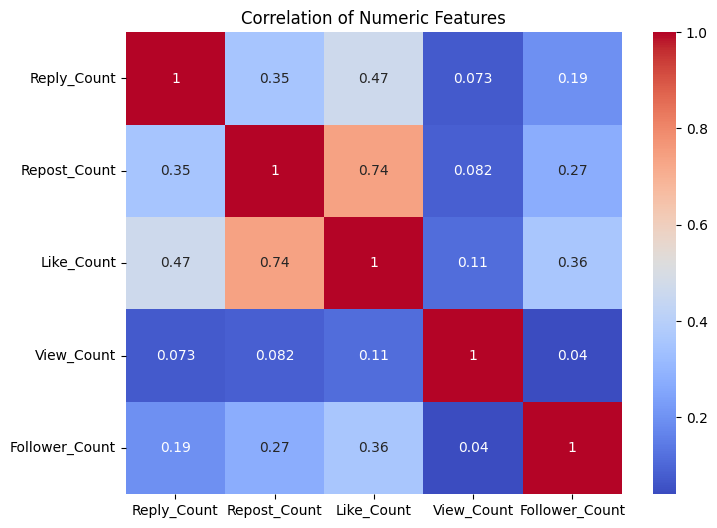

In [ ]:
# Correlation heatmap
corr = final_data[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation of Numeric Features')
plt.show()


As shown above, the mostly correlated variables are the Like_count and Repost_count variables, which does seem to make sense, as a higher like count would often also yield a higher amount of reposts, as posts getting more likes tend to exhibit more virality in terms of users attributing more authenticity to posts with many likes, being more likely to repost it.

In [ ]:
# Correlations
mapping = {'positive': 1, 'neutral': 0, 'negative': -1}

data = final_data.copy()
data['Sentiment'] = data['Prediction'].map(mapping)

influence_metrics = [
    'Reply_Count', 'Repost_Count', 'Like_Count',
    'View_Count', 'Follower_Count', 'Verified_Status',
    'Sentiment']

correlation_matrix = data[influence_metrics].corr()
print(correlation_matrix)

                 Reply_Count  Repost_Count  Like_Count  View_Count  \
Reply_Count         1.000000      0.352489    0.465815    0.072846   
Repost_Count        0.352489      1.000000    0.738675    0.081827   
Like_Count          0.465815      0.738675    1.000000    0.112557   
View_Count          0.072846      0.081827    0.112557    1.000000   
Follower_Count      0.194916      0.272939    0.355816    0.039805   
Verified_Status     0.033907      0.077254    0.094807    0.009102   
Sentiment           0.003096      0.011190    0.009654    0.006305   

                 Follower_Count  Verified_Status  Sentiment  
Reply_Count            0.194916         0.033907   0.003096  
Repost_Count           0.272939         0.077254   0.011190  
Like_Count             0.355816         0.094807   0.009654  
View_Count             0.039805         0.009102   0.006305  
Follower_Count         1.000000         0.137484  -0.062680  
Verified_Status        0.137484         1.000000   0.050445  
Senti

Based on these correlations, we can clearly see that there are not very strong linear correlations of any of the influence metrics on sentiment. Interestingly, however, we notice that although every other metric has a positive impact, i.e., higher reply, repost, like, view follower and if it is verified satus, there is higher sentiment (more positive). However, on the contrary, increase in follower count has a negative impact on sentiment. (fewer followers = more positive sentiment?) note, that these are individual impacts, we can also add interaction variables that could have a different impact on sentiment...

**Type of day analysis**

If you have timestamps, explore how post engagement varies by hour.

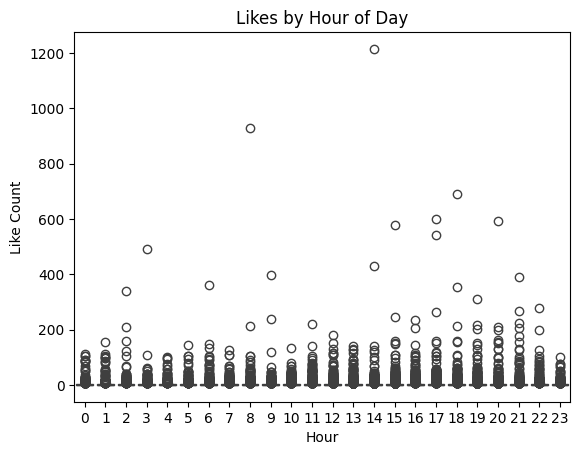

In [ ]:
final_data['Hour'] = final_data['Date'].dt.hour
sns.boxplot(x='Hour', y='Like_Count', data=final_data)
plt.title("Likes by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Like Count")
plt.show()

It seems kind of equal in terms of likes by hour of day, however, by the end of the day, it looks like there is a slight peak, which declines again at the very end of the day.

# Verified vs. Non-Verified Comparison
Determine if verified accounts exhibit different sentiment or engagement patterns.

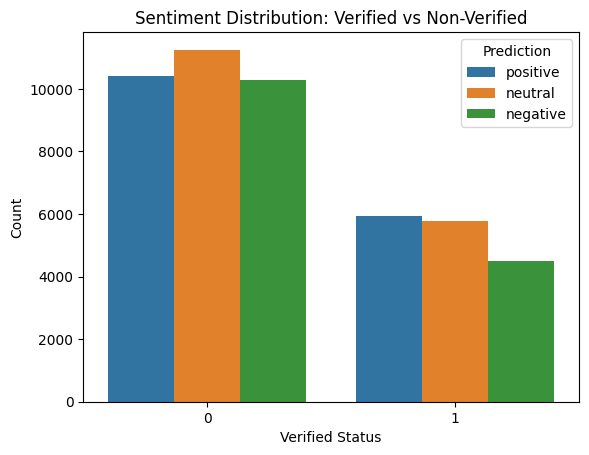

In [ ]:
sns.countplot(x='Verified_Status', hue='Prediction', data=final_data)
plt.title("Sentiment Distribution: Verified vs Non-Verified")
plt.xlabel("Verified Status")
plt.ylabel("Count")
plt.show()

The distribution of verified accounts is rather unbalanced, as there are quite a lot more non-verified accounts than there are verified accounts.

In [ ]:
final_data.columns

Index(['Author_Handle', 'Date', 'X_Post', 'Reply_Count', 'Repost_Count',
       'Like_Count', 'View_Count', 'Follower_Count', 'Verified_Status',
       'Prediction', 'Confidence', 'Replying_to', 'Hour'],
      dtype='object')

In [ ]:
#invite people for the Kaggle party
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Scatterplot

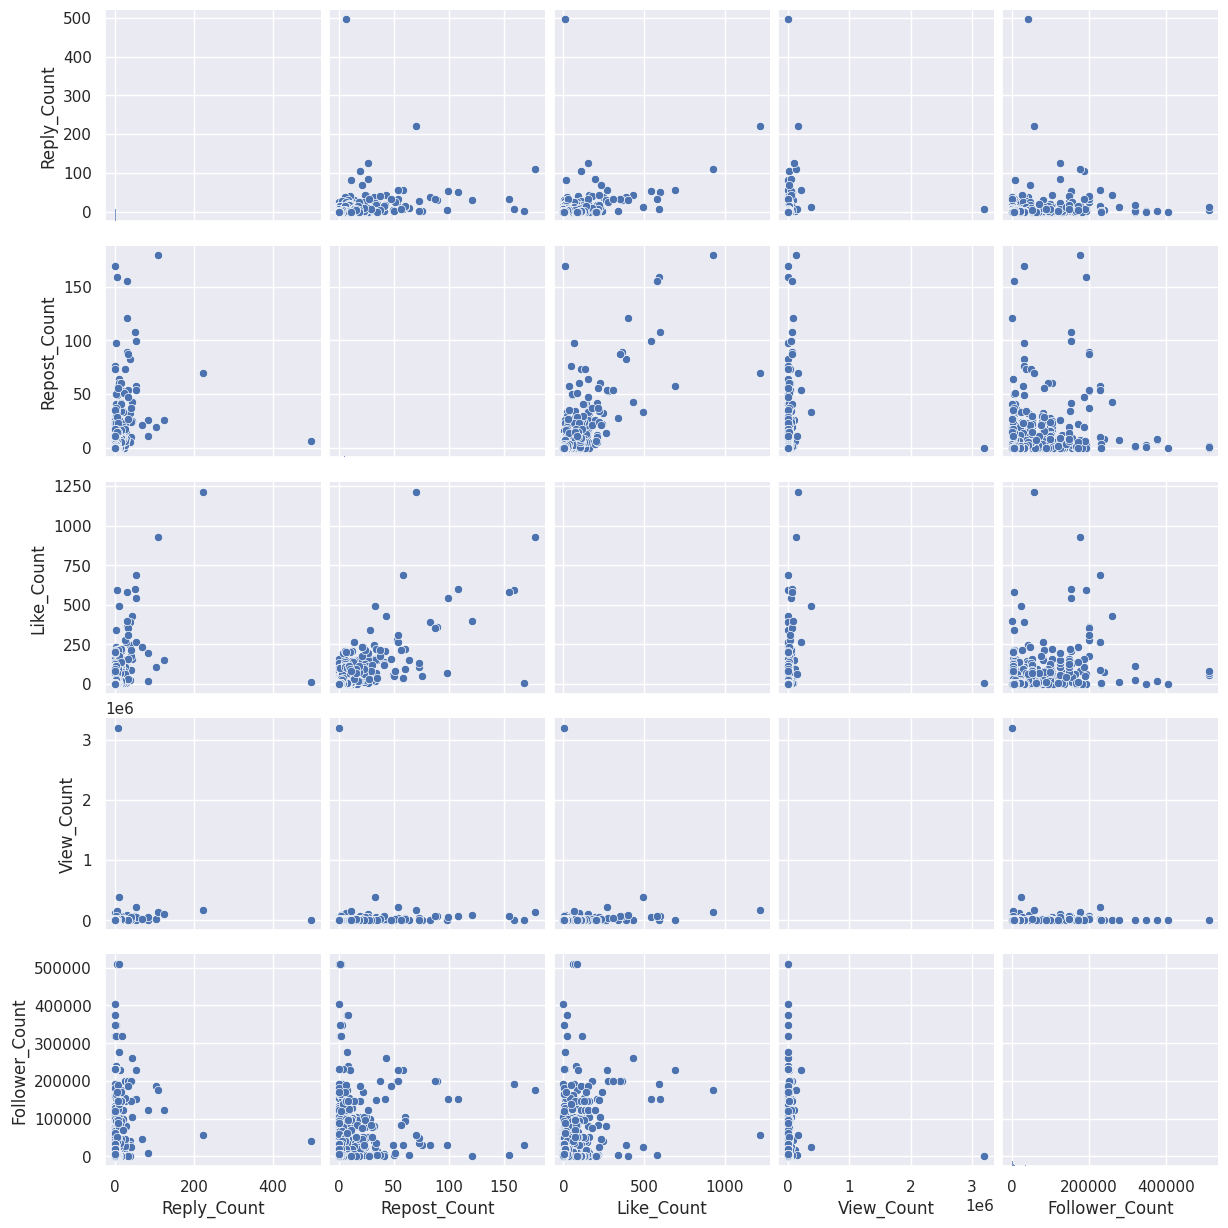

In [ ]:
#scatterplot
sns.set()
sns.pairplot(final_data[numeric_cols], size = 2.5)
plt.show();

As mentioned earlier, it is evident in the scatterplot as well, that Like_Count and Repost_count are the most correlated variables, as an increasing line can almost be drawn, showing how the amount of reposts increase when likes increase.